In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [2]:
import scipy as sc

In [3]:
import arviz as az
import pymc3 as pm

In [4]:
import seaborn as sns

In [5]:
az.style.use('arviz-darkgrid')

In [6]:
sns.set_palette("Dark2_r")
sns.set_style("darkgrid")

### Multiple Linear Regression

In [7]:
data = pd.read_csv("./data/waffle_divorce.csv",sep=';')

In [8]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [8]:
data['MedianAgeMarriage_s'] = (data.MedianAgeMarriage - data.MedianAgeMarriage.mean()) / data.MedianAgeMarriage.std()

In [11]:
with pm.Model() as model_1:
    a = pm.Normal('alpha',mu=10,sd=10)
    b = pm.Normal('beta',mu=10,sd=10)
    mu_age = pm.Deterministic('mu',a + b*data.MedianAgeMarriage_s)
    sigma = pm.Uniform('sigma',0,10)
    y = pm.Normal('y',mu=mu_age,sd=sigma,observed=data.Divorce)
    
    trace_1 = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2667.15draws/s]


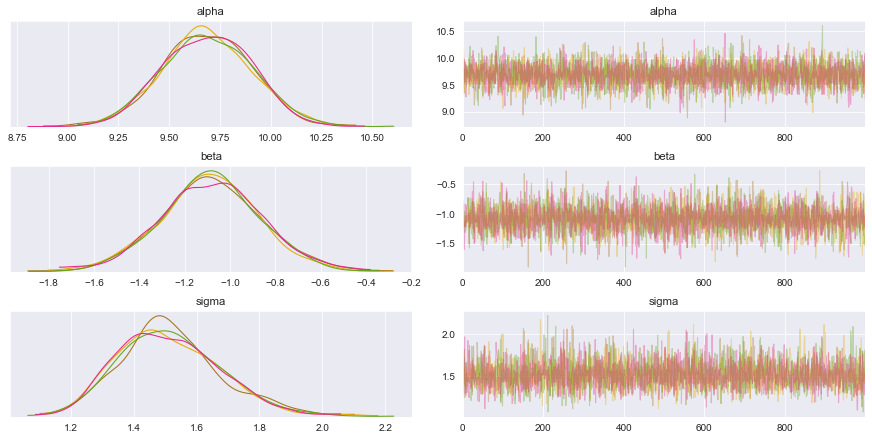

In [71]:
az.plot_trace(trace_1,var_names='~mu_age');

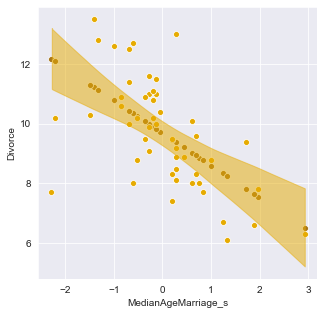

In [69]:
plt.figure(figsize=(5,5))
sns.scatterplot(data.MedianAgeMarriage_s,trace_1['mu'].mean(0),markers=',')
sns.scatterplot(data.MedianAgeMarriage_s,data.Divorce)
az.plot_hpd(data.MedianAgeMarriage_s,trace_1['mu']);

In [9]:
data['Marriage_s'] = (data.Marriage - data.Marriage.mean()) / data.Marriage.std()

In [14]:
with pm.Model() as model_2:
    a = pm.Normal('alpha',mu=10,sd=10)
    b = pm.Normal('beta',mu=10,sd=10)
    mu_marriage = pm.Deterministic('mu',a + b*data.Marriage_s)
    sigma = pm.Uniform('sigma',0,10)
    y = pm.Normal('y',mu=mu_marriage,sd=sigma,observed=data.Divorce)
    
    trace_2 = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2857.28draws/s]


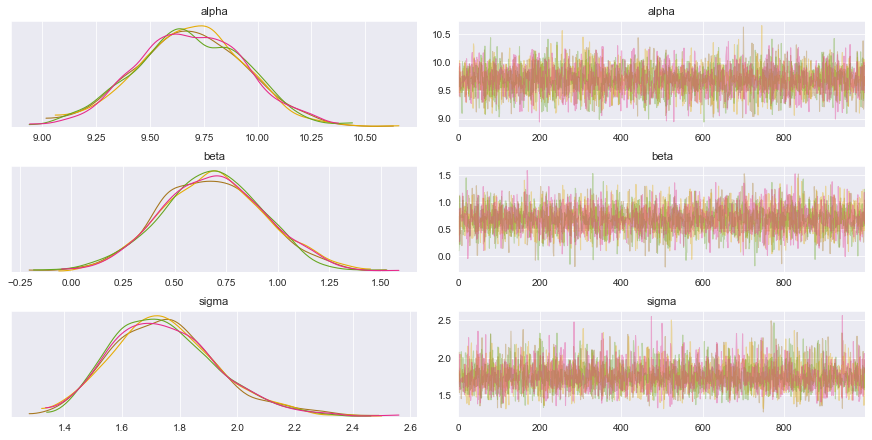

In [73]:
az.plot_trace(trace_2,var_names='~mu_marriage');

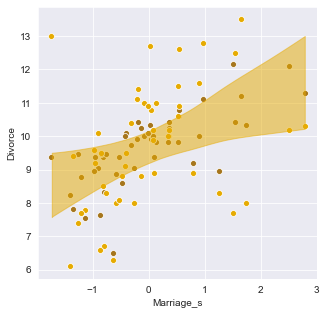

In [75]:
plt.figure(figsize=(5,5))
sns.scatterplot(data.Marriage_s,trace_1['mu'].mean(0),markers=',')
sns.scatterplot(data.Marriage_s,data.Divorce)
az.plot_hpd(data.Marriage_s,trace_2['mu']);

In [36]:
with pm.Model() as model_3:
    a = pm.Normal('alpha',mu=10,sd=10)
    b = pm.Normal('beta',mu=10,sd=10,shape=2)
    mu_mlr = pm.Deterministic('mu',a + b[0]*data.Marriage_s + b[1]*data.MedianAgeMarriage_s)
    sigma = pm.Uniform('sigma',0,10)
    y = pm.Normal('y',mu=mu_mlr,sd=sigma,observed=data.Divorce)
    
    trace_3 = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1776.38draws/s]
The acceptance probability does not match the target. It is 0.8802247381274884, but should be close to 0.8. Try to increase the number of tuning steps.


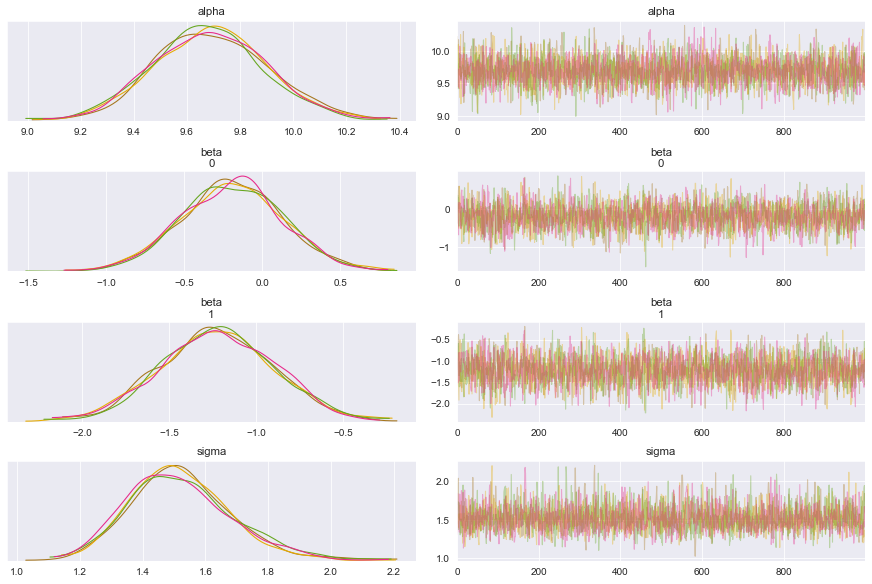

In [77]:
az.plot_trace(trace_3,var_names='~mu_mlr');

In [78]:
az.summary(trace_3,var_names='~mu')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,9.689,0.212,9.314,10.107,0.004,0.003,3278.0,3264.0,3310.0,2444.0,1.0
beta[0],-0.192,0.322,-0.813,0.396,0.006,0.005,2522.0,1862.0,2524.0,2194.0,1.0
beta[1],-1.222,0.326,-1.806,-0.600,0.006,0.004,2645.0,2627.0,2640.0,2631.0,1.0
sigma,1.523,0.164,1.233,1.835,0.003,0.002,3033.0,2952.0,3124.0,2460.0,1.0


**1. We idneitfied that marriage rate is a spurrios variable**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x133925dd0>],
      dtype=object)

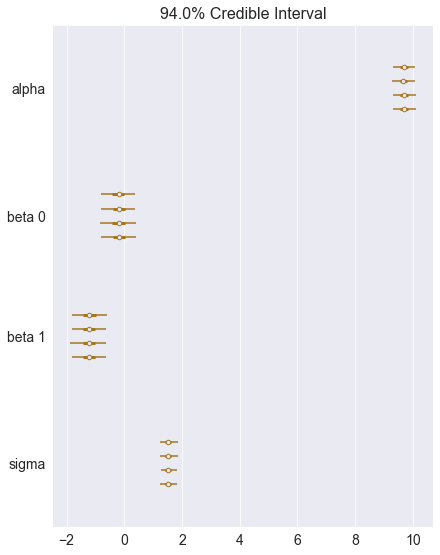

In [79]:
pm.forestplot(trace_3,var_names='~mu')

### Let try to see spurrious vars throught posterior predictive checks:

### Residual plot

1. Regress predictor with other predictors

In [16]:
with pm.Model() as model_regress:
    a = pm.Normal('alpha',mu=10,sd=10)
    b = pm.Normal('beta',mu=10,sd=10,shape=1)
    mu_mlr = pm.Deterministic('mu',a + b*data.Marriage_s )
    sigma = pm.Uniform('sigma',0,10)
    y = pm.Normal('y',mu=mu_mlr,sd=sigma,observed=data.MedianAgeMarriage_s)
    
    trace_regress = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3052.68draws/s]


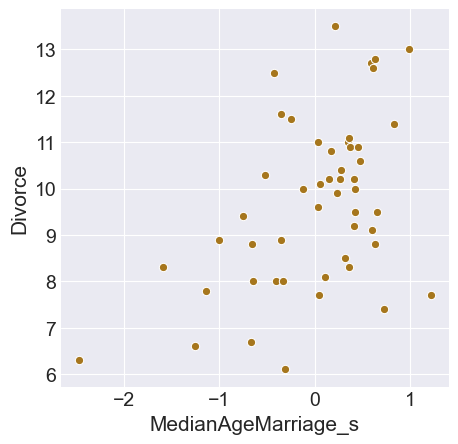

In [17]:
plt.figure(figsize=(5,5))
sns.scatterplot(trace_regress['mu'].mean(0)-data.MedianAgeMarriage_s,data.Divorce);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 2 divergences: 100%|██████████| 8000/8000 [00:21<00:00, 365.18draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7021886498283904, but should be close to 0.8. Try to increase the number of tuning steps.


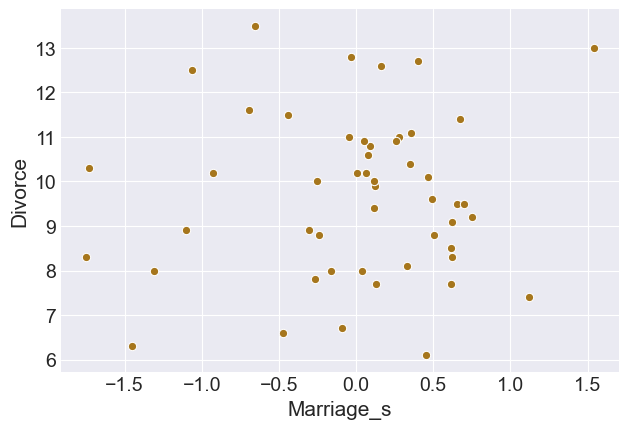

In [18]:
with pm.Model() as model_regress:
    a = pm.Normal('alpha',mu=10,sd=10)
    b = pm.Normal('beta',mu=10,sd=10,shape=1)
    mu_mlr = pm.Deterministic('mu',a + b*data.MedianAgeMarriage )
    sigma = pm.Uniform('sigma',0,10)
    y = pm.Normal('y',mu=mu_mlr,sd=sigma,observed=data.Marriage_s)
    
    trace_regress = pm.sample(1000,tune=1000)

sns.scatterplot(trace_regress['mu'].mean(0)-data.Marriage_s,data.Divorce);

### CounterFactual plots

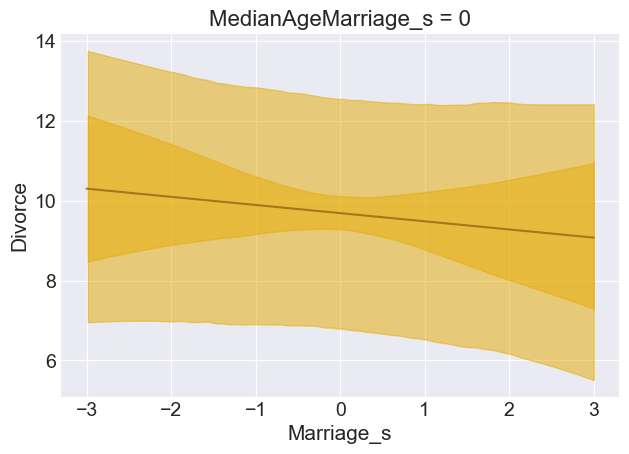

In [38]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_3['alpha'] + trace_3['beta'][:,0] * R_avg[:,None]
divorce_ = sc.stats.norm.rvs(mu_pred, trace_3['sigma'])

plt.plot(R_avg, mu_pred.mean(1), 'C0')
az.plot_hpd(R_avg, mu_pred.T)
az.plot_hpd(R_avg, divorce_.T)

plt.xlabel('Marriage_s')
plt.ylabel('Divorce')
plt.title('MedianAgeMarriage_s = 0');

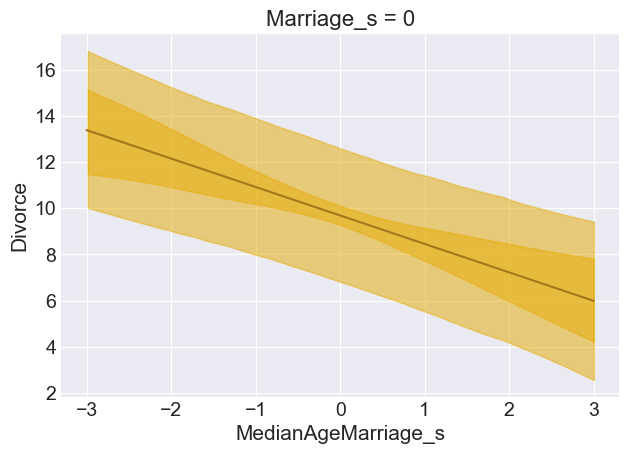

In [39]:
mu_pred = trace_3['alpha'] + trace_3['beta'][:,1] * R_avg[:,None]
divorce_ = sc.stats.norm.rvs(mu_pred, trace_3['sigma'])

plt.plot(R_avg, mu_pred.mean(1), 'C0')
az.plot_hpd(R_avg, mu_pred.T)
az.plot_hpd(R_avg, divorce_.T)

plt.xlabel('MedianAgeMarriage_s')
plt.ylabel('Divorce')
plt.title('Marriage_s = 0');

### Posterior Prediction Checks:

Check the predictions

## Masked Variables

In [49]:
varnames=['~mu']

In [46]:
milk_data = pd.read_csv("./data/milk.csv",sep=';').dropna()

In [47]:
milk_data.columns

Index(['clade', 'species', 'kcal.per.g', 'perc.fat', 'perc.protein',
       'perc.lactose', 'mass', 'neocortex.perc'],
      dtype='object')

In [48]:
with pm.Model() as model_5:
    a = pm.Normal('alpha', mu=10, sd=100)
    bn = pm.Normal('beta', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * milk_data['neocortex.perc'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=milk_data['kcal.per.g'])
    trace_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 69 divergences: 100%|██████████| 8000/8000 [00:13<00:00, 575.51draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4992052008949109, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7099703156166141, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6947749282629576, but should be close to 0.8. Try to increase t

In [51]:
az.summary(trace_5, varnames, credible_interval=.89).round(3)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.383,0.555,-0.497,1.214,0.019,0.014,897.0,784.0,900.0,983.0,1.01
beta,0.004,0.008,-0.008,0.017,0.000,0.000,898.0,851.0,900.0,966.0,1.01
sigma,0.193,0.040,0.136,0.243,0.002,0.002,340.0,340.0,220.0,139.0,1.02


**we see very less influence on target**

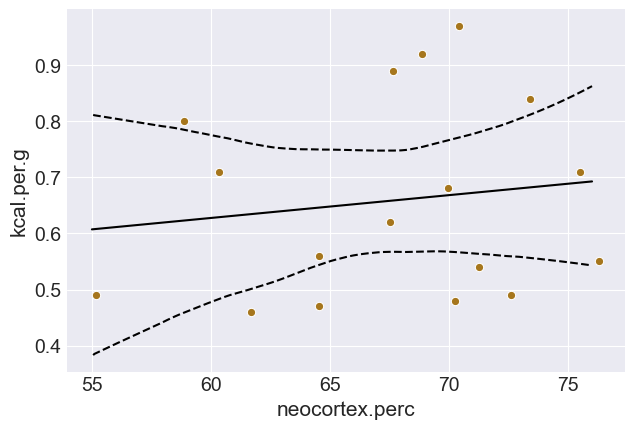

In [55]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5['alpha'] + trace_5['beta'] * seq[:,None]

sns.scatterplot(milk_data['neocortex.perc'], milk_data['kcal.per.g'])

plt.plot(seq, mu_pred.mean(1), 'k')
az.plot_hpd(seq, mu_pred.T,
            fill_kwargs={'alpha': 0},
            plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'});


#### lets check another variable

In [56]:
milk_data['log_mass'] = np.log(milk_data['mass'])


In [59]:
with pm.Model() as model_6:
    a = pm.Normal('alpha', mu=10, sd=100)
    bn = pm.Normal('beta', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * milk_data['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=milk_data['kcal.per.g'])
    trace_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2367.51draws/s]


In [60]:
az.summary(trace_6, varnames, credible_interval=.89).round(3)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.705,0.058,0.614,0.798,0.001,0.001,1901.0,1882.0,1934.0,2176.0,1.0
beta,-0.032,0.024,-0.069,0.006,0.001,0.000,1652.0,1479.0,1662.0,1738.0,1.0
sigma,0.183,0.036,0.132,0.237,0.001,0.001,1878.0,1878.0,1950.0,2086.0,1.0


**we see negative correlation**

In [61]:
with pm.Model() as model_7:
    a = pm.Normal('alpha', mu=10, sd=100)
    bn = pm.Normal('beta', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn[0] * milk_data['neocortex.perc'] + bn[1] * milk_data['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=milk_data['kcal.per.g'])
    trace_7 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 30 divergences: 100%|██████████| 8000/8000 [00:27<00:00, 295.68draws/s]
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6288580789266457, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


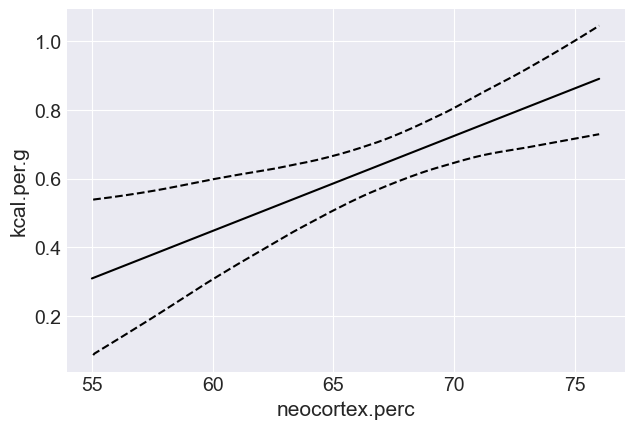

In [62]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_7['alpha'] + trace_7['beta'][:,0] * seq[:,None] + trace_7['beta'][:,1] * milk_data['log_mass'].mean()

plt.plot(seq, mu_pred.mean(1), 'k')
az.plot_hpd(seq, mu_pred.T,
            fill_kwargs={'alpha': 0},
            plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'})

plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g');


#### we see that the variable was being masked because on negative effect of other variable.

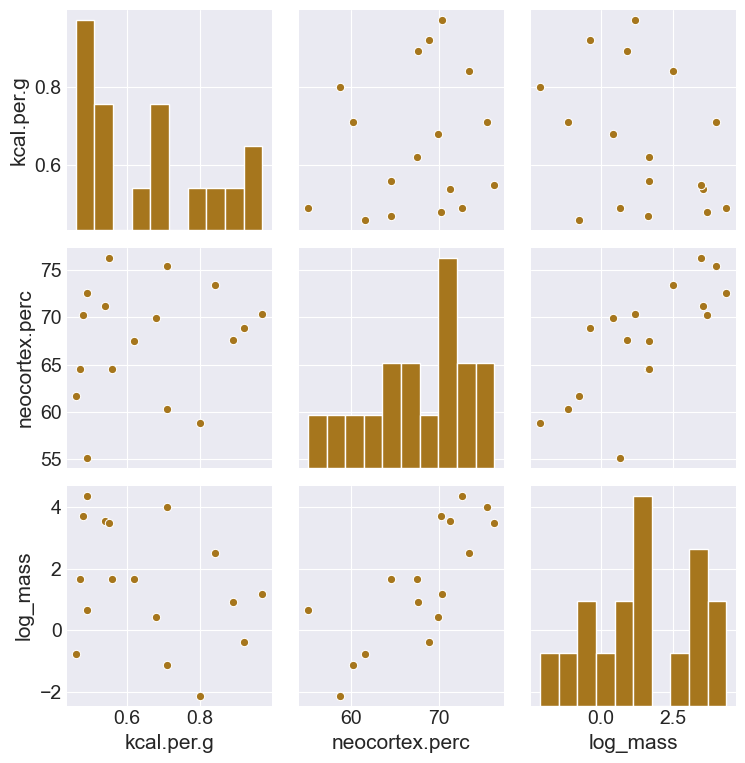

In [64]:
sns.pairplot(milk_data[['kcal.per.g','neocortex.perc','log_mass']]);

**Synthetic masket association**

M <- U -> N
|--->K<---|

In [79]:
n = 100
# U = sc.stats.norm.rvs(loc=10,scale=2,size=100)
N = sc.stats.norm.rvs(loc=2,scale=1,size=100)
M = sc.stats.norm.rvs(loc=2,scale=1,size=100)

In [92]:
K = sc.stats.norm.rvs(loc=M-N,scale=1,size=100)

In [93]:
dummy = pd.DataFrame({'m':M,'n':N,'k':K})

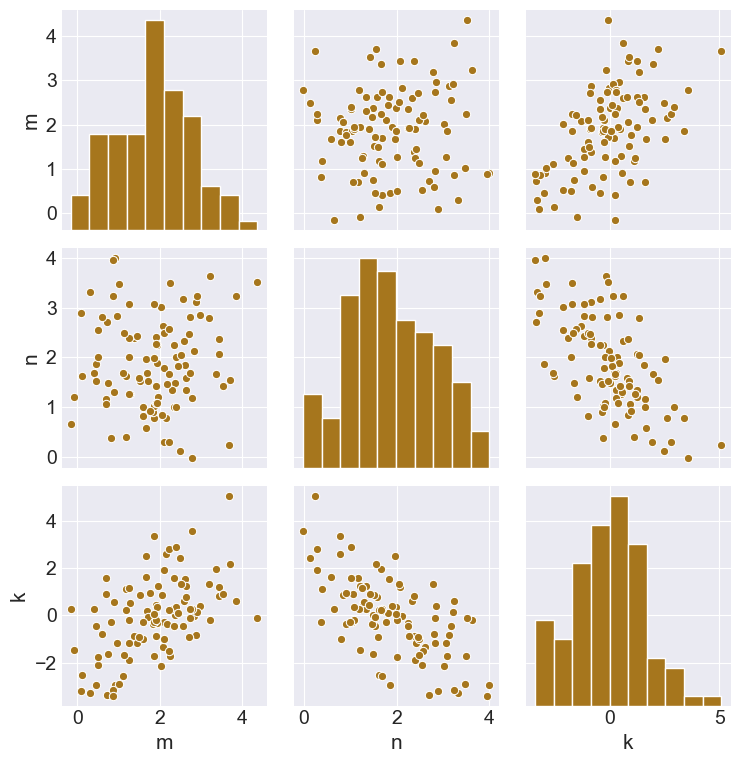

In [94]:
sns.pairplot(dummy);

In [91]:
dummy.corr()

,m,n,k
m,1.000000,0.037874,0.196591
n,0.037874,1.000000,-0.258732
k,0.196591,-0.258732,1.000000


In [64]:
with pm.Model() as model_mask:
    alpha = pm.Normal("alpha",mu=10,sigma=2)
    beta = pm.Normal("beta",mu=1,sigma=2)
    sigma = pm.Normal("sigma",mu=1,sigma=3)
    mu = pm.Deterministic('mu',alpha+beta*dummy.n)
    K = pm.Normal("k",mu=mu,sigma=sigma,observed=dummy.k)
    trace_mask = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2750.35draws/s]


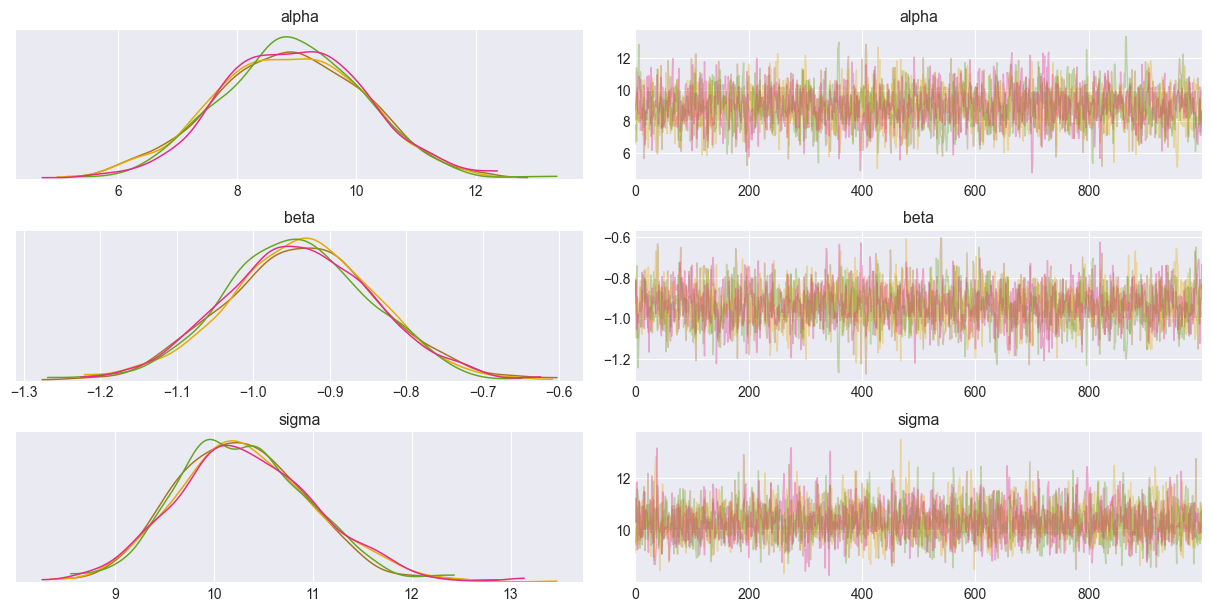

In [65]:
az.plot_trace(trace_mask,var_names='~mu');

## Dummy Vars

**better to have indicator for them**